In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
from keras_model import build_model

In [2]:
df = pd.read_csv('..\\data\\processed2\\processed_data2.csv', index_col=0)
df_games = pd.read_csv('..\\data\\processed2\\final_dataset_games2.csv', index_col=1)
df_games.drop("Unnamed: 0", axis=1, inplace=True)

In [3]:
df.sort_values(by=['date', 'gameid'], inplace=True)
df.reset_index(0, drop=True, inplace=True)

In [4]:
n_batters = len(df['res batter'].unique())
n_pitchers = len(df['res pitcher'].unique())

In [5]:
n_batters

2793

In [6]:
df['event_final'] = df['event_final'].astype('category')

In [7]:
df['event_final_code'] = df['event_final'].cat.codes

In [8]:
cats = df['event_final'].astype('category')
bats = df['res batter'].astype('category')
pits = df['res pitcher'].astype('category')

outcome_dict = {}
for i, cat in enumerate(cats.cat.categories):
    outcome_dict[cat] = i
outcome_dict_rev = dict(enumerate(cats.cat.categories))
N_outcomes = len(outcome_dict)

bat_dict = {}
for i, bat in enumerate(bats.cat.categories):
    bat_dict[bat] = i
bat_dict_rev = dict(enumerate(bats.cat.categories))

pit_dict = {}
for i, pit in enumerate(pits.cat.categories):
    pit_dict[pit] = i
pit_dict_rev = dict(enumerate(pits.cat.categories))

In [9]:
ev_order=df['event_final'].value_counts().index
order = []
for ev in ev_order:
    order += [outcome_dict[ev]]

In [10]:
df[(df['year']==2019)]

,gameid,opp,inning,batting team,outs,balls,strikes,pitch sequence,visiting_score,home_score,...,advances,num_pitches,strikeout looking,fouls,event_final,modifier simple,first,second,third,event_final_code
1662421,OAK201903200,SEA,1,0,0,1,0,BX,0,0,...,NaN,2,False,1,9L,L,0,0,0,37
1662422,OAK201903200,SEA,1,0,1,0,2,CCFX,0,0,...,NaN,4,False,2,3P,P,0,0,0,14
1662423,OAK201903200,SEA,1,0,2,0,0,X,0,0,...,NaN,1,False,1,S6L,L,0,0,0,91
1662424,OAK201903200,SEA,1,0,2,2,2,BBCSS,0,0,...,NaN,5,False,1,K,NaN,0,1,0,72
1662425,OAK201903200,SEA,1,1,0,0,2,FCS,0,0,...,NaN,3,False,1,K,NaN,0,0,0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848933,WAS201909290,CLE,8,1,1,1,2,SCBS,2,8,...,NaN,4,False,1,K,NaN,1,0,1,72
1848934,WAS201909290,CLE,8,1,2,0,0,X,2,8,...,NaN,1,False,1,7F,F,1,0,1,29
1848935,WAS201909290,CLE,9,0,0,3,2,BBCFBB,2,8,...,NaN,6,False,1,W,NaN,0,0,0,111
1848936,WAS201909290,CLE,9,0,0,2,1,BBFX,2,8,...,NaN,4,False,1,5G,G,1,0,0,21


In [11]:
test = range(1680191, 1848937)

In [12]:
df = df.loc[test]

In [13]:
game_groups = df.groupby('gameid')

In [14]:
games = list(df.gameid.unique())

In [15]:
# games

In [16]:
sim_model = tf.keras.models.load_model('..\\models\\situation_prediction_tanh3')

In [17]:
pred_model = build_model(n_batters, n_pitchers, 8, 6, 12, 113, 1 )
pred_model.load_weights('..\\models\\prediction_model_v2_4')

In [18]:
def update_situation(situation, outcome, model):
    vals = np.array(list(situation.values()))[3:].astype(np.float32)
    vals = vals.reshape(1, -1).astype(np.float32)
    outcome = np.array([[outcome]]).astype(np.int32)
    pred = model.predict([vals, outcome])
    pred = [np.squeeze(p) for p in pred]
    valid = False
    count = 0
    while not valid and count < 20:
        count += 1
        outs = situation['outs'] + np.random.choice(pred[0].shape[0], p=pred[0])
        half_inning = situation['half inning']
        inning = 0
        if outs > 2:
            half_inning = np.absolute(situation['half inning']-1)
            if not half_inning:
                inning = 1
            visiting_score = 0
            home_score = 0
            first = second = third = 0
            outs = 0
        else:
            visiting_score = np.random.choice(pred[1].shape[0], p=pred[1])
            home_score = np.random.choice(pred[2].shape[0], p=pred[2])
            first = np.random.choice(2, p=[1-pred[3], pred[3]])
            second = np.random.choice(2, p=[1-pred[4], pred[4]])
            third = np.random.choice(2, p=[1-pred[5], pred[5]])
        situation_out = {'inning diff' : inning,
                         'home score diff' : home_score,
                         'visiting score diff' : visiting_score,
                         'half inning' : half_inning,
                         'outs' : outs,
                         'first' : first,
                         'second' : second,
                         'third' : third}
        valid, update = compare_situation(situation, situation_out)
        situation_out = update
    situation_out['inning'] = situation['inning'] + situation_out['inning diff']
    situation_out['home score'] = situation['home score'] + situation_out['home score diff']
    situation_out['visiting score'] = situation['visiting score'] + situation_out['visiting score diff']
    return situation_out, pred

def compare_situation(situation, update, verbose=0):
    base_runners = situation['first'] + situation['second'] + situation['third']
    base_runners_update = update['first'] + update['second'] + update['third']
    base_runners_diff = base_runners_update - base_runners
    if update['half inning'] != situation['half inning']:
        return True, update
    elif base_runners_diff > 1:
        if verbose:
            print('too many base runners')
        return False, update
    elif update['half inning']:
        if (update['outs'] - situation['outs'] + update['home score diff'] - 1 != -base_runners_diff):
            if verbose:
                print('outs: '+str(update['outs']-situation['outs']))
                print('home score diff: '+str(update['home score diff']))
                print('base runners: '+str(update['first'])+', '+str(update['second'])+', '+str(update['third']))
            return False, update
        else:
            return True, update
    elif not update['half inning']:
        if (update['outs'] - situation['outs'] + update['visiting score diff'] - 1 != -base_runners_diff):
            if verbose:
                print('outs: '+str(update['outs']-situation['outs']))
                print('visiting score diff: '+str(update['visiting score diff']))
                print('base runners: '+str(update['first'])+', '+str(update['second'])+', '+str(update['third']))
            return False, update
        else:
            return True, update
    else:
        return True, update

def get_sit_feed(sit, out, outcome_dict):
    sit_feed = {'inning' : sit[0],
                'home score' : sit[4], 
                'visiting score' : sit[3],
                'half inning' : sit[1],
                'outs' : sit[2],
                'first' : sit[5],
                'second' : sit[6],
                'third' : sit[7]}
    return sit_feed, outcome_dict[out]

In [19]:
home_bat_cols = [c for c in df_games.columns if 'home batter' in c]
visit_bat_cols = [c for c in df_games.columns if 'visitor batter' in c]

In [20]:
def get_lineups(game_df, home_bat_cols=home_bat_cols, visit_bat_cols=visit_bat_cols):
    home_pitcher = game_df.loc['home starting pitcher']
    visit_pitcher = game_df.loc['visiting starting pitcher']
    home_lineup = game_df.loc[home_bat_cols]
    visitor_lineup = game_df.loc[visit_bat_cols]
    for i, h in enumerate(home_lineup):
        if h not in bat_dict.keys():
            home_lineup[i] = 'aardd001'
    for i, v in enumerate(visitor_lineup):
        if v not in bat_dict.keys():
            visitor_lineup[i] = 'aardd001'
    return home_pitcher, visit_pitcher, home_lineup.values, visitor_lineup.values

In [21]:
def simulate_game(game_df, innings=5, verbose=False):
    home_pitcher, visit_pitcher, home_lineup, visitor_lineup = get_lineups(game_df)
    prev_batter = 0
    prev_pitcher = 0
    prev_outcome = 0
    prev_pitch_count = [0, 0, 0]
    prev_situation = [0, 0, 0, 0, 0, 0, 0, 0]
    visit_order = 0
    home_order = 0
    at_bats = 0
    home_pitches = 0
    visitor_pitches = 0
    outcomes = []
    situation = {'inning': 0, 'half inning': 0,
                 'outs': 0, 'visiting score': 0,
                 'home score': 0, 'first': 0,
                 'second': 0, 'third': 0}
    situations = [situation]
    batters = []
    while (situation['inning'] < innings) & (at_bats < 100):
        at_bats += 1
        if situation['half inning'] == 0:
            batters += [visitor_lineup[visit_order%len(visitor_lineup)]]
            batter = bat_dict[batters[-1]]
            pitcher = pit_dict[home_pitcher] + n_batters
        else:
            batters += [home_lineup[home_order%len(home_lineup)]]
            batter = bat_dict[batters[-1]]
            pitcher = pit_dict[visit_pitcher] + n_batters
        prev_batter = np.array([[[prev_batter]]]).astype(np.int32)
        prev_pitcher = np.array([[[prev_pitcher]]]).astype(np.int32)
        prev_situation = np.array([[prev_situation]]).astype(np.float32)
        prev_outcome = np.array([[prev_outcome]]).astype(np.int32)
        prev_pitch_count = np.array([[prev_pitch_count]]).astype(np.float32)
        batter = np.array([[[batter]]]).astype(np.int32)
        pitcher = np.array([[[pitcher]]]).astype(np.int32)
        sitch = np.array([[[situation['inning'], situation['half inning'], 
                   situation['outs'], situation['visiting score'], 
                   situation['home score'], situation['first'], 
                   situation['second'], situation['third']]]]).astype(np.float32)
        outcome_pred, pitch_count_pred = pred_model([prev_batter, prev_pitcher, prev_situation,
            prev_outcome, prev_pitch_count, batter, pitcher, sitch])
        if situation['half inning'] == 0:
            home_pitches += np.round(np.sum(pitch_count_pred))
        else:
            visitor_pitches += np.round(np.sum(pitch_count_pred))
        prev_batter = np.squeeze(batter)
        prev_pitcher = np.squeeze(pitcher)
        prev_pitch_count = np.squeeze(pitch_count_pred)
        prev_situation = np.squeeze(sitch)
        visit_order += 1
        home_order += 1
        p = np.squeeze(outcome_pred.numpy())
        outcome = np.random.choice(p.shape[0], p=p)
        prev_outcome = outcome
        outcomes += [outcome_dict_rev[outcome]]
        sit_feed, dummy = get_sit_feed(np.squeeze(sitch), outcome, outcome_dict_rev)
        if verbose:
            print('situation')
            print(sit_feed)
            print('outcome')
            print(outcome_dict_rev[outcome])
        situation, pred = update_situation(sit_feed, outcome, sim_model)
        situations += [situation]
    return outcomes, situations, batters

In [22]:
def update_state(game):
    df_game = df.loc[game_groups.groups[game]]
    df_game = pd.concat((df_game, df_game.iloc[-1:, :]), axis=0)
    batters = df_game['res batter'].values
    situation = df_game[['inning', 'batting team', 'outs', 'visiting_score', 'home_score', 'first', 'second', 'third']].values
    batters = df_game['res batter']
    batter = []
    for bat in batters:
        batter += [bat_dict[bat]]
    pitchers = df_game['res pitcher']
    pitcher = []
    for pit in pitchers:
        pitcher += [pit_dict[pit]]
    batter = np.array(batter)
    pitcher = np.array(pitcher) + n_batters
    balls = df_game['balls'].values
    strikes = df_game['strikes'].values
    fouls = df_game['fouls'].values
    outcome = np.expand_dims(df_game['event_final_code'].values, axis=0).astype(np.int32)
    situation[:, 0] -= 1
    batter_ex = np.expand_dims(np.expand_dims(batter, axis=1), axis=0).astype(np.int32)
    pitcher_ex = np.expand_dims(np.expand_dims(pitcher, axis=1), axis=0).astype(np.int32)
    pitch_count = np.expand_dims(np.concatenate(
        (np.expand_dims(balls, axis=1), np.expand_dims(strikes, axis=1), np.expand_dims(fouls, axis=1)), axis=1), axis=0).astype(np.float32)
    situation = np.expand_dims(situation, axis=0).astype(np.float32)
    for i in range(len(df_game)-1):
        predictions = pred_model([batter_ex[:1, i:i+1], pitcher_ex[:1, i:i+1], situation[:1, i:i+1], outcome[:1, i:i+1], pitch_count[:1, i:i+1], batter_ex[:1, i+1:i+2], pitcher_ex[:1, i+1:i+2], situation[:1, i+1:i+2]])
    state_0 = pred_model.layers[9].states[0].numpy()
    #state_1 = pred_model.layers[10].states[0].numpy()
    return state_0

In [23]:
state_start = np.load('..\\models\\prediction_model_v2_state_3.npy')
#state_start_1 = np.load('..\\models\\prediction_model_v4_state_1.npy')

In [24]:
logic = np.logical_and(np.logical_and(df['inning']==6, df['outs']==0), df['batting team']==0)
df_f5_scores = df[logic].groupby('gameid').first()[['visiting_score', 'home_score']]

In [25]:
df_games = pd.concat((df_games, df_f5_scores), axis=1)

In [ ]:
situations = {}
bins_spread = np.linspace(-6.5, 6.5, 14)
bins_total = np.linspace(-0.5, 15.5, 17)
bins = np.linspace(0, 10, 11)
state_0 = np.expand_dims(state_start, axis=0)
for game in games:
    print(game)
    situations[game] = []
    for i in range(5):
        pred_model.layers[9].reset_states(states=state_0)
        if (i + 1) % 10 == 0:
            print('game iter: '+str(i+1))
        outcomes_i, situations_i, batters_i = simulate_game(df_games.loc[game], verbose=0)
        situations[game] += [[situations_i[-1]['visiting score'], situations_i[-1]['home score']]]
    situations[game] = np.stack(situations[game])
    print('median delta (home_score - visiting_score)')
    print(np.median(situations[game][:,1] - situations[game][:,0], axis=0))
    print('median over/under (visiting_score + home_score)')
    print(np.median(situations[game][:,0] + situations[game][:,1], axis=0))
    print(df_games.loc[game, ['visiting_score', 'home_score']])
    # print('visiting score distribution:')
    # print(np.histogram(situations[game][:,0], bins=bins)[0])
    # print('home score distribution:')
    # print(np.histogram(situations[game][:,1], bins=bins)[0])
    # plt.hist(situations[game][:,0], bins=bins, alpha=0.4, label='visitor score')
    # plt.hist(situations[game][:,1], bins=bins, alpha=0.4, label='home score')
    # plt.xlabel('score')
    # plt.legend()
    # plt.ylim([0, 30])
    # plt.show()
    # plt.hist(situations[game][:,1]-situations[game][:,0], bins=bins_spread, alpha=0.4)
    # plt.xlabel('spread (home-away)')
    # plt.ylim([0, 30])
    # plt.show()
    # plt.hist(situations[game][:,0]+situations[game][:,1], bins=bins_total, alpha=0.4)
    # plt.xlabel('total')
    # plt.ylim([0, 30])
    # plt.show()
    pred_model.layers[9].reset_states(states=state_0)
    state_0 = update_state(game)

In [ ]:
import joblib

In [ ]:
joblib.dump(situations, '../data/processed2/2019_simulations_v0_3.joblib')

In [26]:
from sklearn.manifold import TSNE

In [37]:
non_zero_batters = np.where((np.absolute(np.sum(state_start[:n_batters], axis=1)) > 0))[0]
non_zero_pitchers = np.where((np.absolute(np.sum(state_start[n_batters:], axis=1)) > 0))[0]

In [43]:
state_start[non_zero_pitchers+n_batters]

array([[-0.01301946, -0.9056928 , -0.9820902 , ..., -0.5775871 ,
        -0.65777874, -0.49798113],
       [ 0.38302767,  0.98548526,  0.45480382, ..., -0.70822656,
         0.9986458 , -0.02408577],
       [ 0.47895393, -0.333902  ,  0.70302176, ..., -0.2427092 ,
         0.98685163, -0.22662331],
       ...,
       [ 0.03088923, -0.3393649 ,  0.10265318, ..., -0.78189915,
         0.9975834 , -0.76943433],
       [ 0.54293734, -0.6884558 , -0.18571302, ..., -0.6251141 ,
         0.5092454 , -0.21260415],
       [-0.01595273, -0.93477184,  0.31425166, ..., -0.08214442,
         0.99845946, -0.7155755 ]], dtype=float32)

In [38]:
tsne = TSNE(verbose=1)
state_cluster_batters = tsne.fit_transform(state_start[non_zero_batters])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 999 samples in 0.000s...
[t-SNE] Computed neighbors for 999 samples in 0.040s...
[t-SNE] Computed conditional probabilities for sample 999 / 999
[t-SNE] Mean sigma: 0.324891
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.287033
[t-SNE] KL divergence after 1000 iterations: 0.862688


In [44]:
tsne = TSNE(verbose=1)
state_cluster_pitchers = tsne.fit_transform(state_start[non_zero_pitchers+n_batters])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 816 samples in 0.004s...
[t-SNE] Computed neighbors for 816 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 816 / 816
[t-SNE] Mean sigma: 0.293073
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.053360
[t-SNE] KL divergence after 1000 iterations: 0.909001


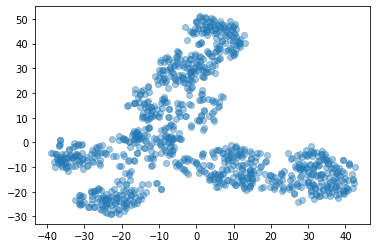

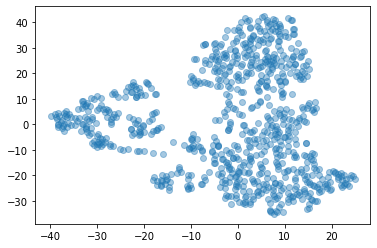

In [45]:
plt.scatter(state_cluster_batters[:,0], state_cluster_batters[:,1], alpha=0.4)
plt.show()

plt.scatter(state_cluster_pitchers[:,0], state_cluster_pitchers[:,1], alpha=0.4)
plt.show()

In [66]:
np.argmax(state_cluster_pitchers, axis=0)

array([811, 250], dtype=int64)

In [69]:
non_zero_pitchers[250]

667

In [70]:
pit_dict_rev[667]

'garcg002'